In [1]:
%matplotlib inline
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

import numpy as np

from scipy import ndimage as ndi
from scipy import stats

from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)

# Introduction to three-dimensional image processing

Images are represented as `numpy` arrays. A single-channel, or grayscale, image is a 2D matrix of pixel intensities of shape `(row, column)`. We can construct a 3D volume as a series of 2D `planes`, giving 3D images the shape `(plane, row, column)`. Multichannel data adds a `channel` dimension in the final position containing color information. 

These conventions are summarized in the table below:


|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

Some 3D images are constructed with equal resolution in each dimension; e.g., a computer generated rendering of a sphere. Most experimental data captures one dimension at a lower resolution than the other two; e.g., photographing thin slices to approximate a 3D structure as a stack of 2D images. The distance between pixels in each dimension, called `spacing`, is encoded in a tuple and is accepted as a parameter by some `skimage` functions and can be used to adjust contributions to filters.

## Input/Output and display

Three dimensional data can be loaded with `skimage.io.imread`. The data for this tutorial was provided by the Allen Institute for Cell Science. It has been downsampled by a factor of 4 in the `row` and `column` dimensions to reduce computational time.

In [2]:
data = io.imread("cells.tif")

print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))
print("range: ({}, {})".format(data.min(), data.max()))

shape: (60, 256, 256)
dtype: float64
range: (0.0, 1.0)


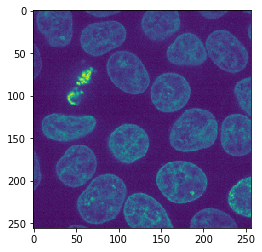

In [10]:
plt.imshow(data[32])

The distance between pixels was reported by the microscope used to image the cells. This `spacing` information will be used to adjust contributions to filters and helps decide when to apply operations planewise. We've chosen to normalize it to `1.0` in the `row` and `column` dimensions.

In [5]:
# The microscope reports the following spacing
original_spacing = np.array([0.2900000, 0.0650000, 0.0650000])

# We downsampled each slice 4x to make the data smaller
rescaled_spacing = original_spacing * [1, 4, 4]

# Normalize the spacing so that pixels are a distance of 1 apart
spacing = rescaled_spacing / rescaled_spacing[2]

print("microscope spacing: {}\n".format(original_spacing))
print("after rescaling images: {}\n".format(rescaled_spacing))
print("normalized spacing: {}\n".format(spacing))

microscope spacing: [0.29  0.065 0.065]

after rescaling images: [0.29 0.26 0.26]

normalized spacing: [1.11538462 1.         1.        ]



To illustrate (no need to read the following cell; execute to generate illustration).

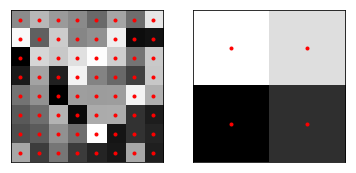

In [6]:
# To make sure we all see the same thing
np.random.seed(0)

image = np.random.random((8, 8))
image_rescaled = transform.downscale_local_mean(image, (4, 4))

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.imshow(image, cmap='gray')
ax0.set_xticks([])
ax0.set_yticks([])
centers = np.indices(image.shape).reshape(2, -1).T
ax0.plot(centers[:, 0], centers[:, 1], '.r')

ax1.imshow(image_rescaled, cmap='gray')
ax1.set_xticks([])
ax1.set_yticks([])
centers = np.indices(image_rescaled.shape).reshape(2, -1).T
ax1.plot(centers[:, 0], centers[:, 1], '.r');

Back to our original data, let's try visualizing the image with `skimage.io.imshow`.

Invalid dimensions for image data


/zopt/conda2/envs/nanshenv3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


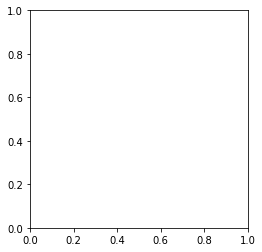

In [7]:
try:
    io.imshow(data, cmap="gray")
except TypeError as e:
    print(str(e))

`skimage.io.imshow` can only display grayscale and RGB(A) 2D images. We can use `skimage.io.imshow` to visualize 2D planes. By fixing one axis, we can observe three different views of the image.

In [8]:
def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if title:
        ax.set_title(title)

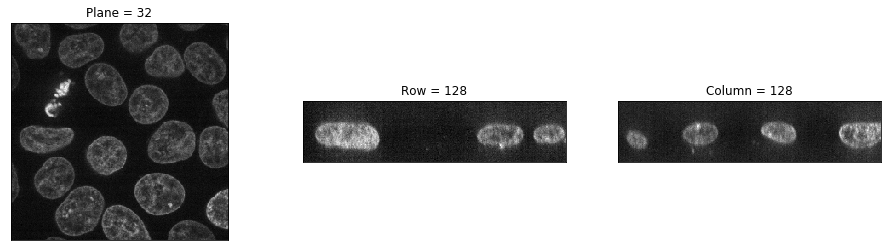

In [9]:
_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

show_plane(a, data[32], title="Plane = 32")
show_plane(b, data[:, 128, :], title="Row = 128")
show_plane(c, data[:, :, 128], title="Column = 128")

Three-dimensional images can be viewed as a series of two-dimensional functions. The `display` helper function displays 30 planes of the provided image. By default, every other plane is displayed.

In [11]:
def slice_in_3D(ax, i):
    # From:
    # https://stackoverflow.com/questions/44881885/python-draw-3d-cube

    import numpy as np
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

    Z = np.array([[0, 0, 0],
                  [1, 0, 0],
                  [1, 1, 0],
                  [0, 1, 0],
                  [0, 0, 1],
                  [1, 0, 1],
                  [1, 1, 1],
                  [0, 1, 1]])

    Z = Z * data.shape

    r = [-1,1]

    X, Y = np.meshgrid(r, r)
    # plot vertices
    ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])

    # list of sides' polygons of figure
    verts = [[Z[0], Z[1], Z[2], Z[3]],
             [Z[4], Z[5], Z[6], Z[7]], 
             [Z[0], Z[1], Z[5], Z[4]], 
             [Z[2], Z[3], Z[7], Z[6]], 
             [Z[1], Z[2], Z[6], Z[5]],
             [Z[4], Z[7], Z[3], Z[0]], 
             [Z[2], Z[3], Z[7], Z[6]]]

    # plot sides
    ax.add_collection3d(
        Poly3DCollection(verts, facecolors=(0, 1, 1, 0.25), linewidths=1,
                         edgecolors='darkblue')
    )

    verts = np.array([[[0, 0, 0],
                       [0, 0, 1],
                       [0, 1, 1],
                       [0, 1, 0]]])
    verts = verts * (60, 256, 256)
    verts += [i, 0, 0]

    ax.add_collection3d(Poly3DCollection(verts, 
     facecolors='magenta', linewidths=1, edgecolors='black'))

    ax.set_xlabel('plane')
    ax.set_ylabel('col')
    ax.set_zlabel('row')

    # Auto-scale plot axes
    scaling = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    ax.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]] * 3)

    #plt.show()

In [12]:
from ipywidgets import interact

def slice_explorer(data, cmap='gray'):
    N = len(data)
        
    @interact(plane=(0, N - 1))
    def display_slice(plane=34):
        fig, ax = plt.subplots(figsize=(20, 5))
        
        ax_3D = fig.add_subplot(133, projection='3d')
        
        show_plane(ax, data[plane], title="Plane {}".format(plane), cmap=cmap)
        slice_in_3D(ax_3D, plane)
        
        plt.show()

    return display_slice

In [13]:
slice_explorer(data);

interactive(children=(IntSlider(value=34, description='plane', max=59), Output()), _dom_classes=('widget-interact',))

In [14]:
def display(im3d, cmap="gray", step=2):
    _, axes = plt.subplots(nrows=5, ncols=6, figsize=(16, 14))
    
    vmin = im3d.min()
    vmax = im3d.max()
    
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])

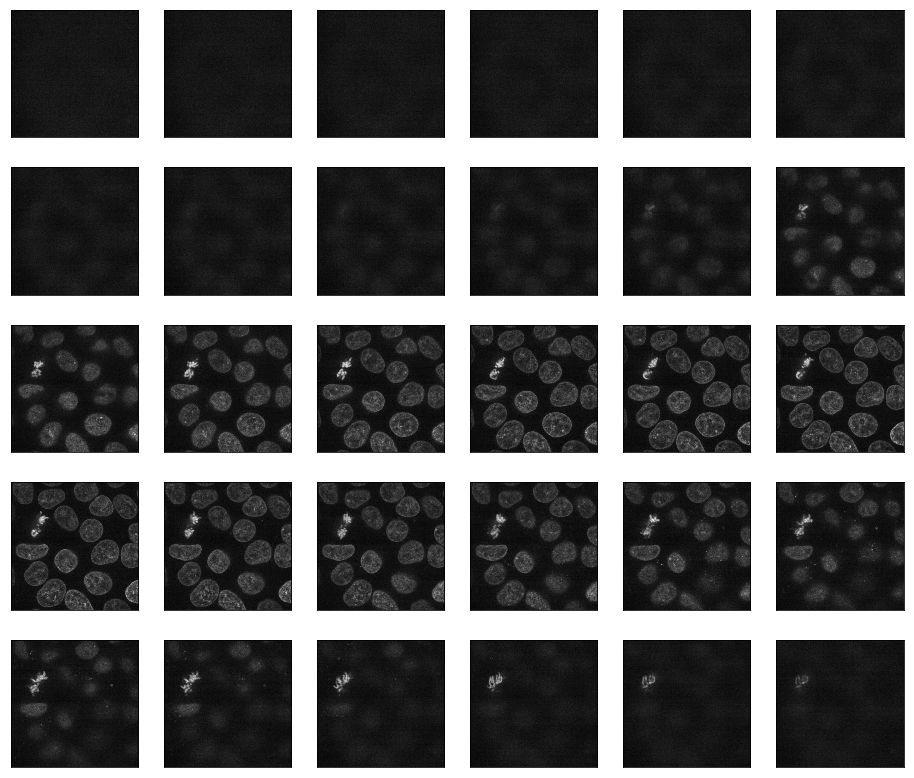

In [15]:
display(data)

## Exposure

`skimage.exposure` contains a number of functions for adjusting image contrast. These functions operate on pixel values. Generally, image dimensionality or pixel spacing does not need to be considered.

[Gamma correction](https://en.wikipedia.org/wiki/Gamma_correction), also known as Power Law Transform, brightens or darkens an image. The function $O = I^\gamma$ is applied to each pixel in the image. A `gamma < 1` will brighten an image, while a `gamma > 1` will darken an image. 

In [16]:
# Helper function for plotting histograms.
def plot_hist(ax, data, title=None):
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    
    if title:
        ax.set_title(title)

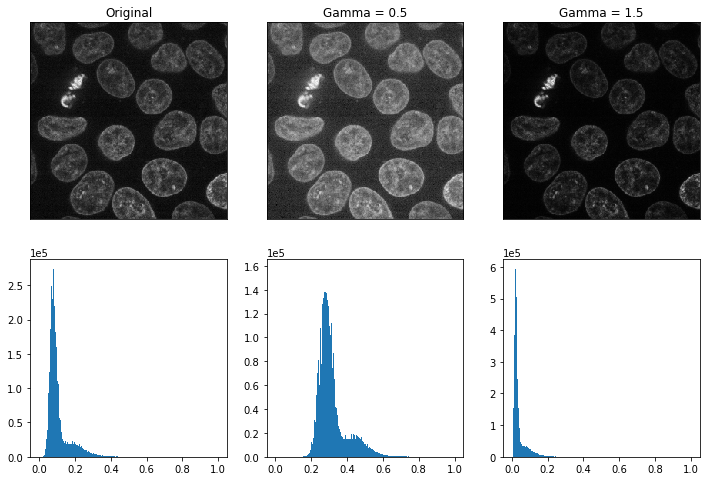

In [17]:
gamma_low_val = 0.5
gamma_low = exposure.adjust_gamma(data, gamma=gamma_low_val)

gamma_high_val = 1.5
gamma_high = exposure.adjust_gamma(data, gamma=gamma_high_val)

_, ((a, b, c), (d, e, f)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

show_plane(a, data[32], title="Original")
show_plane(b, gamma_low[32], title="Gamma = {}".format(gamma_low_val))
show_plane(c, gamma_high[32], title="Gamma = {}".format(gamma_high_val))

plot_hist(d, data)
plot_hist(e, gamma_low)
plot_hist(f, gamma_high)

[Histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) improves contrast in an image by redistributing pixel intensities. The most common pixel intensities are spread out, allowing areas of lower local contrast to gain a higher contrast. This may enhance background noise.

interactive(children=(IntSlider(value=34, description='plane', max=59), Output()), _dom_classes=('widget-interact',))

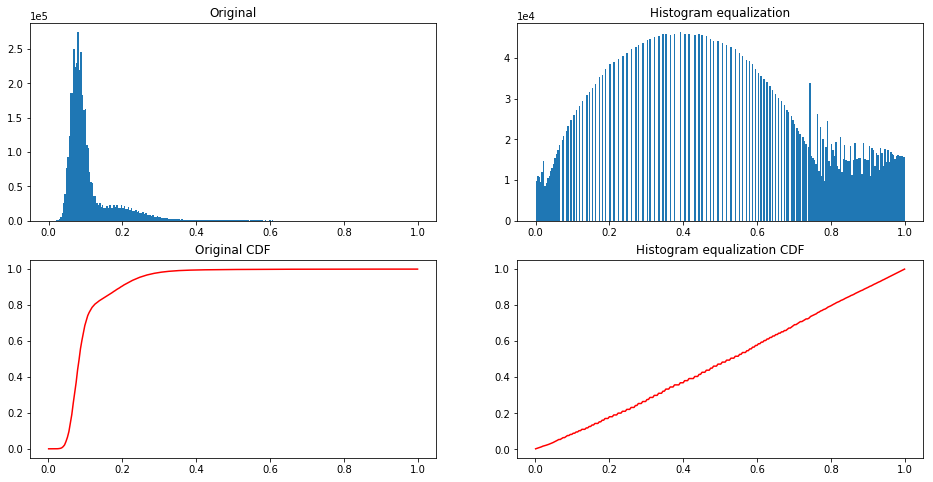

In [18]:
equalized = exposure.equalize_hist(data)

slice_explorer(equalized)

_, ((a, b), (c, d)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

plot_hist(a, data, title="Original")
plot_hist(b, equalized, title="Histogram equalization")

cdf, bins = exposure.cumulative_distribution(data.ravel())
c.plot(bins, cdf, "r")
c.set_title("Original CDF")

cdf, bins = exposure.cumulative_distribution(equalized.ravel())
d.plot(bins, cdf, "r")
d.set_title("Histogram equalization CDF");

Most experimental images are affected by salt and pepper noise. A few bright artifacts can decrease the relative intensity of the pixels of interest. A simple way to improve contrast is to clip the pixel values on the lowest and highest extremes. Clipping the darkest and brightest 0.5% of pixels will increase the overall contrast of the image.

In [19]:
vmin, vmax = stats.scoreatpercentile(data, (0.5, 99.5))

clipped = exposure.rescale_intensity(
    data, 
    in_range=(vmin, vmax), 
    out_range=np.float32
).astype(np.float32)

slice_explorer(clipped);

interactive(children=(IntSlider(value=34, description='plane', max=59), Output()), _dom_classes=('widget-interact',))

In [20]:
# We'll call our dataset "rescaled" from here on
# In this cell, you can choose any of the previous results
# to continue working with.
#
# We'll use the `clipped` version
#
rescaled = clipped

## Edge detection

[Edge detection](https://en.wikipedia.org/wiki/Edge_detection) highlights regions in the image where a sharp change in contrast occurs. The intensity of an edge corresponds to the steepness of the transition from one intensity to another. A gradual shift from bright to dark intensity results in a dim edge. An abrupt shift results in a bright edge.

The [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) is an edge detection algorithm which approximates the gradient of the image intensity, and is fast to compute. `skimage.filters.sobel` has not been adapted for 3D images. It can be applied planewise to approximate a 3D result.

In [21]:
sobel = np.empty_like(rescaled)

for plane, image in enumerate(rescaled):
    sobel[plane] = filters.sobel(image)

slice_explorer(sobel);

interactive(children=(IntSlider(value=34, description='plane', max=59), Output()), _dom_classes=('widget-interact',))

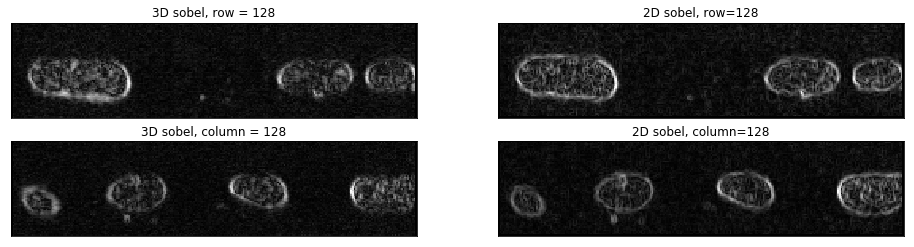

In [22]:
_, ((a, b), (c, d)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 4))

show_plane(a, sobel[:, 128, :], title="3D sobel, row = 128")

row_sobel = filters.sobel(rescaled[:, 128, :])
show_plane(b, row_sobel, title="2D sobel, row=128")

show_plane(c, sobel[:, :, 128], title="3D sobel, column = 128")

column_sobel = filters.sobel(rescaled[:, :, 128])
show_plane(d, column_sobel, title="2D sobel, column=128")

## Filters

In addition to edge detection, `skimage.filters` provides functions for filtering and thresholding images.

[Gaussian filter](https://en.wikipedia.org/wiki/Gaussian_filter) applies a Gaussian function to an image, creating a smoothing effect. `skimage.filters.gaussian` takes as input `sigma` which can be a scalar or a sequence of scalar. This `sigma` determines the standard deviation of the Gaussian along each axis. When the resolution in the `plane` dimension is much worse than the `row` and `column` dimensions, dividing `base_sigma` by the image `spacing` will balance the contribution to the filter along each axis.

In [23]:
base_sigma = 3.0

sigma = base_sigma / spacing

gaussian = filters.gaussian(rescaled, multichannel=False, sigma=sigma)

slice_explorer(gaussian);

interactive(children=(IntSlider(value=34, description='plane', max=59), Output()), _dom_classes=('widget-interact',))

[Median filter](https://en.wikipedia.org/wiki/Median_filter) is a noise removal filter. It is particularly effective against salt and pepper noise. An additional feature of the median filter is its ability to preserve edges. This is helpful in segmentation because the original shape of regions of interest will be preserved.

`skimage.filters.median` does not support three-dimensional images and needs to be applied planewise.

In [24]:
rescaled_uint8 = util.img_as_ubyte(rescaled)

median = np.empty_like(rescaled_uint8)

for plane, image in enumerate(rescaled_uint8):
    median[plane] = filters.median(image)
    
median = util.img_as_float(median)
    
slice_explorer(median);

/zopt/conda2/envs/nanshenv3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


interactive(children=(IntSlider(value=34, description='plane', max=59), Output()), _dom_classes=('widget-interact',))

A [bilateral filter](https://en.wikipedia.org/wiki/Bilateral_filter) is another edge-preserving, denoising filter. Each pixel is assigned a weighted average based on neighboring pixels. The weight is determined by spatial and radiometric similarity (e.g., distance between two colors).

`skimage.restoration.denoise_bilateral` requires a `multichannel` parameter. This determines whether the last axis of the image is to be interpreted as multiple channels or another spatial dimension. While the function does not yet support 3D data, the `multichannel` parameter will help distinguish multichannel 2D data from grayscale 3D data.

In [25]:
bilateral = np.empty_like(rescaled)

for index, plane in enumerate(rescaled):
    bilateral[index] = restoration.denoise_bilateral(
        plane, 
        multichannel=False
    )

slice_explorer(bilateral);

interactive(children=(IntSlider(value=34, description='plane', max=59), Output()), _dom_classes=('widget-interact',))

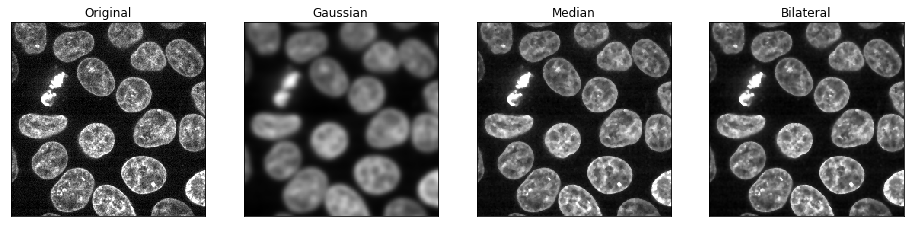

In [26]:
_, (a, b, c, d) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

show_plane(a, rescaled[32], title="Original")
show_plane(b, gaussian[32], title="Gaussian")
show_plane(c, median[32], title="Median")
show_plane(d, bilateral[32], title="Bilateral")

In [27]:
denoised = median

[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. Thresholding is a form of image segmentation.

Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and Li's minimum cross entropy threshold are two common algorithms. The example below demonstrates how a small difference in the threshold value can visibly alter the binarized image.

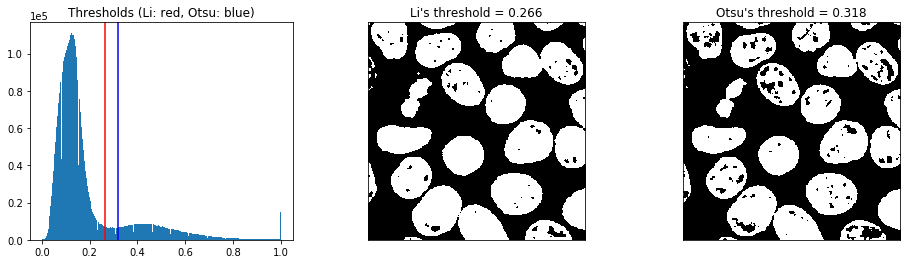

In [28]:
threshold_li = filters.threshold_li(denoised)
li = denoised >= threshold_li

threshold_otsu = filters.threshold_otsu(denoised)
otsu = denoised >= threshold_otsu

_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

plot_hist(a, denoised, "Thresholds (Li: red, Otsu: blue)")
a.axvline(threshold_li, c="r")
a.axvline(threshold_otsu, c="b")

show_plane(b, li[32], title="Li's threshold = {:0.3f}".format(threshold_li))
show_plane(c, otsu[32], title="Otsu's threshold = {:0.3f}".format(threshold_otsu))

In [30]:
binary = li

slice_explorer(binary);

interactive(children=(IntSlider(value=34, description='plane', max=59), Output()), _dom_classes=('widget-interact',))

## Morphological operations

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`. Structuring elements are shapes which define areas over which an operation is applied. The response to the filter indicates how well the neighborhood corresponds to the structuring element's shape.

There are a number of two and three dimensional structuring elements defined in `skimage.morphology`. Not all 2D structuring element have a 3D counterpart. The simplest and most commonly used structuring elements are the `disk`/`ball` and `square`/`cube`.

In [31]:
ball = morphology.ball(radius=5)
print("ball shape: {}".format(ball.shape))

cube = morphology.cube(width=5)
print("cube shape: {}".format(cube.shape))

ball shape: (11, 11, 11)
cube shape: (5, 5, 5)


The most basic mathematical morphology operations are `dilation` and `erosion`. Dilation enlarges bright regions and shrinks dark regions. Erosion shrinks bright regions and enlarges dark regions. Other morphological operations are composed of `dilation` and `erosion`.

The `closing` of an image is defined as a `dilation` followed by an `erosion`. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features. Morphological `opening` on an image is defined as an `erosion` followed by a `dilation`. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.

These operations in `skimage.morphology` are compatible with 3D images and structuring elements. A 2D structuring element cannot be applied to a 3D image, nor can a 3D structuring element be applied to a 2D image.

These four operations (`closing`, `dilation`, `erosion`, `opening`) have binary counterparts which are faster to compute than the grayscale algorithms.

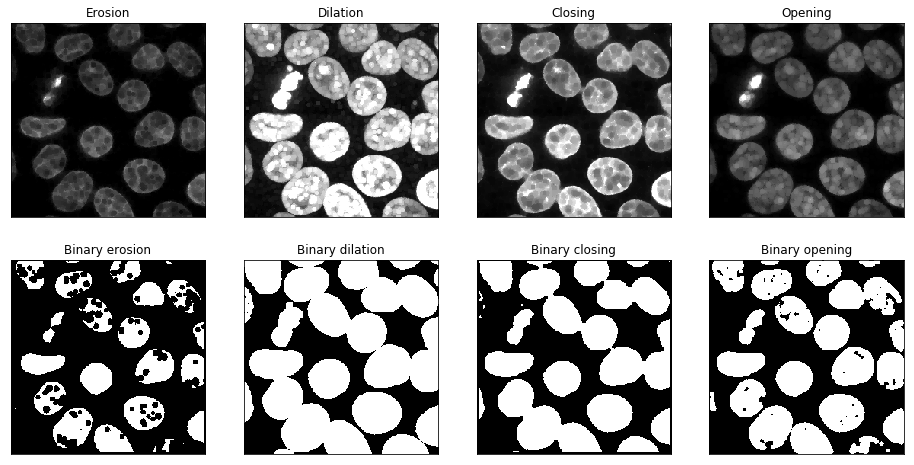

In [32]:
selem = morphology.ball(radius=3)

closing = morphology.closing(rescaled, selem=selem)
dilation = morphology.dilation(rescaled, selem=selem)
erosion = morphology.erosion(rescaled, selem=selem)
opening = morphology.opening(rescaled, selem=selem)

binary_closing = morphology.binary_closing(binary, selem=selem)
binary_dilation = morphology.binary_dilation(binary, selem=selem)
binary_erosion = morphology.binary_erosion(binary, selem=selem)
binary_opening = morphology.binary_opening(binary, selem=selem)

_, ((a, b, c, d), (e, f, g, h)) = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

show_plane(a, erosion[32], title="Erosion")
show_plane(b, dilation[32], title="Dilation")
show_plane(c, closing[32], title="Closing")
show_plane(d, opening[32], title="Opening")

show_plane(e, binary_erosion[32], title="Binary erosion")
show_plane(f, binary_dilation[32], title="Binary dilation")
show_plane(g, binary_closing[32], title="Binary closing")
show_plane(h, binary_opening[32], title="Binary opening")

Morphology operations can be chained together to denoise an image. For example, a `closing` applied to an `opening` can remove salt and pepper noise from an image.

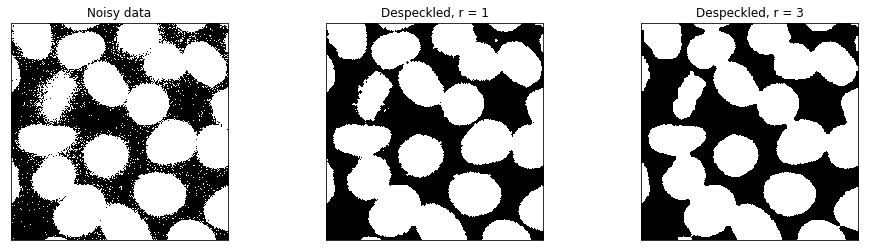

In [33]:
binary_equalized = equalized >= filters.threshold_li(equalized)

despeckled1 = morphology.closing(
    morphology.opening(binary_equalized, selem=morphology.ball(1)),
    selem=morphology.ball(1)
)

despeckled3 = morphology.closing(
    morphology.opening(binary_equalized, selem=morphology.ball(3)),
    selem=morphology.ball(3)
)

_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

show_plane(a, binary_equalized[32], title="Noisy data")
show_plane(b, despeckled1[32], title="Despeckled, r = 1")
show_plane(c, despeckled3[32], title="Despeckled, r = 3")

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. These functions accept an `area_threshold`/`min_size` parameter respectively, which is the minimum size (in pixels) of accepted holes or objects. The threshold can be approximated by a cube.

In [34]:
width = 20

remove_holes = morphology.remove_small_holes(
    binary, 
    area_threshold=width ** 3
)

slice_explorer(remove_holes);

TypeError: remove_small_holes() got an unexpected keyword argument 'area_threshold'

In [35]:
width = 20

remove_objects = morphology.remove_small_objects(
    remove_holes, 
    min_size=width ** 3
)

slice_explorer(remove_objects);

NameError: name 'remove_holes' is not defined

## Segmentation

[Image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) partitions images into regions of interest. Interger labels are assigned to each region to distinguish regions of interest.

In [36]:
labels = measure.label(remove_objects)

slice_explorer(labels, cmap='inferno');

NameError: name 'remove_objects' is not defined

Connected components of the binary image are assigned the same label via `skimage.measure.label`. Tightly packed cells  connected in the binary image are assigned the same label.

In [ ]:
_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

show_plane(a, rescaled[32, :100, 125:], title="Rescaled")
show_plane(b, labels[32, :100, 125:], cmap='inferno', title="Labels")
show_plane(c, labels[32, :100, 125:] == 8, title="Labels = 8")

A better segmentation would assign different labels to disjoint regions in the original image. 

[Watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) can distinguish touching objects. Markers are placed at local minima and expanded outward until there is a collision with markers from another region. The inverse intensity image transforms bright cell regions into basins which should be filled.

In declumping, markers are generated from the distance function. Points furthest from an edge have the highest intensity and should be identified as markers using `skimage.feature.peak_local_max`. Regions with pinch points should be assigned multiple markers.

In [ ]:
distance = ndi.distance_transform_edt(remove_objects)

slice_explorer(distance, cmap='viridis');

In [ ]:
peak_local_max = feature.peak_local_max(
    distance,
    footprint=np.ones((15, 15, 15), dtype=np.bool),
    indices=False,
    labels=measure.label(remove_objects)
)

markers = measure.label(peak_local_max)

labels = morphology.watershed(
    rescaled, 
    markers, 
    mask=remove_objects
)

slice_explorer(labels, cmap='inferno');

After watershed, we have better disambiguation between internal cells.

When cells simultaneous touch the border of the image, they may be assigned the same label.  In pre-processing, we typically remove these cells.

*Note:* This is 3D data—you may not always be able to see connections in 2D!

In [ ]:
_, (a, b) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

show_plane(a, labels[39, 156:, 20:150], cmap='inferno')
show_plane(b, labels[34, 90:190, 126:], cmap='inferno')

The watershed algorithm falsely detected subregions in a few cells. This is referred to as oversegmentation.

In [ ]:
f, ax = plt.subplots()
show_plane(ax, labels[38, 50:100, 20:100], cmap='inferno', title="Labels")

Plotting the markers on the distance image reveals the reason for oversegmentation. Cells with multiple markers will be assigned multiple labels, and oversegmented. It can be observed that cells with a uniformly increasing distance map are assigned a single marker near their center. Cells with uneven distance maps are assigned multiple markers, indicating the presence of multiple local maxima.

In [ ]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

vmin = distance.min()
vmax = distance.max()

offset = 31

for index, ax in enumerate(axes.flatten()):
    ax.imshow(
        distance[offset + index],
        cmap="gray",
        vmin=vmin,
        vmax=vmax
    )
    
    peaks = np.nonzero(peak_local_max[offset + index])
    
    ax.plot(peaks[1], peaks[0], "r.")
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))


show_plane(a, remove_objects[10:, 193:253, 74])
show_plane(b, distance[10:, 193:253, 74])

features = feature.peak_local_max(distance[10:, 193:253, 74])
b.plot(features[:, 1], features[:, 0], 'r.')

# Improve feature selection by blurring, using a larger footprint
# in `peak_local_max`, etc.

smooth_distance = filters.gaussian(distance[10:, 193:253, 74], sigma=5)
show_plane(c, smooth_distance)
features = feature.peak_local_max(
    smooth_distance
)
c.plot(features[:, 1], features[:, 0], 'bx');

## Feature extraction

[Feature extraction](https://en.wikipedia.org/wiki/Feature_extraction) reduces data required to describe an image or objects by measuring informative features. These include features such as area or volume, bounding boxes, and intensity statistics.

Before measuring objects, it helps to clear objects from the image border. Measurements should only be collected for objects entirely contained in the image.

In [ ]:
interior_labels = segmentation.clear_border(labels)
interior_labels = morphology.remove_small_objects(interior_labels, min_size=200)

print("interior labels: {}".format(np.unique(interior_labels)))

slice_explorer(interior_labels, cmap='inferno');

After clearing the border, the object labels are no longer sequentially increasing. The labels can be renumbered such that there are no jumps in the list of image labels.

In [ ]:
relabeled, _, _ = segmentation.relabel_sequential(interior_labels)

print("relabeled labels: {}".format(np.unique(relabeled)))

`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. It's good practice to make measurements on the original image.

Not all properties are supported for 3D data. Below are lists of supported and unsupported 3D measurements.

In [ ]:
regionprops = measure.regionprops(relabeled, intensity_image=data)

supported = [] 
unsupported = []

for prop in regionprops[0]:
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties:")
print("  " + "\n  ".join(supported))
print()
print("Unsupported properties:")
print("  " + "\n  ".join(unsupported))

`skimage.measure.regionprops` ignores the 0 label, which represents the background.

In [ ]:
print("measured regions: {}".format([regionprop.label for regionprop in regionprops]))

In [ ]:
volumes = [regionprop.area for regionprop in regionprops]

print("total pixels: {}".format(volumes))

Collected measurements can be further reduced by computing per-image statistics such as total, minimum, maximum, mean, and standard deviation.

In [ ]:
max_volume = np.max(volumes)
mean_volume = np.mean(volumes)
min_volume = np.min(volumes)
sd_volume = np.std(volumes)
total_volume = np.sum(volumes)

print("Volume statistics")
print("total: {}".format(total_volume))
print("min: {}".format(min_volume))
print("max: {}".format(max_volume))
print("mean: {:0.2f}".format(mean_volume))
print("standard deviation: {:0.2f}".format(sd_volume))

Perimeter measurements are not computed for 3D objects. The 3D extension of perimeter is surface area. We can measure the surface of an object by generating a surface mesh with `skimage.measure.marching_cubes` and computing the surface area of the mesh with `skimage.measure.mesh_surface_area`.

In [ ]:
selected_cell = 4

# skimage.measure.marching_cubes expects ordering (row, col, pln)
volume = (relabeled == regionprops[selected_cell].label).transpose(1, 2, 0)

verts_px0, faces_px0, _, _ = measure.marching_cubes_lewiner(volume, level=0, spacing=(1.0, 1.0, 1.0))
surface_area_pixels = measure.mesh_surface_area(verts_px0, faces_px0)

verts, faces, _, _ = measure.marching_cubes_lewiner(volume, level=0, spacing=tuple(spacing))
surface_area_actual = measure.mesh_surface_area(verts, faces)

print("surface area (total pixels): {:0.2f}".format(surface_area_pixels))
print("surface area (actual): {:0.2f}".format(surface_area_actual))

In [ ]:
selected_cell = 3

# skimage.measure.marching_cubes expects ordering (row, col, pln)
volume = (relabeled == regionprops[selected_cell].label).transpose(1, 2, 0)

verts_px1, faces_px1, _, _ = measure.marching_cubes_lewiner(volume, level=0, spacing=(1.0, 1.0, 1.0))
surface_area_pixels = measure.mesh_surface_area(verts_px0, faces_px0)

verts, faces, _, _ = measure.marching_cubes_lewiner(volume, level=0, spacing=tuple(spacing))
surface_area_actual = measure.mesh_surface_area(verts, faces)

print("surface area (total pixels): {:0.2f}".format(surface_area_pixels))
print("surface area (actual): {:0.2f}".format(surface_area_actual))

The volume can be visualized using the mesh vertexes and faces.

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

mesh = Poly3DCollection(verts_px0[faces_px0])
mesh.set_edgecolor("k")
ax.add_collection3d(mesh)

mesh = Poly3DCollection(verts_px1[faces_px1])
mesh.set_edgecolor("k")
ax.add_collection3d(mesh)

ax.set_xlabel("col")
ax.set_ylabel("row")
ax.set_zlabel("pln")

min_pln, min_row, min_col, max_pln, max_row, max_col = regionprops[selected_cell].bbox

ax.set_xlim(min_row, max_row)
ax.set_ylim(min_col, max_col)
ax.set_zlim(min_pln, max_pln)

plt.tight_layout()
plt.show()

## Challenge problems

Put your 3D image processing skills to the test by working through these challenge problems.

### Improve the segmentation
A few objects were oversegmented in the declumping step. Try to improve the segmentation and assign each object a single, unique label. You can try:

1. generating a smoother image by modifying the `win_size` parameter in `skimage.restoration.denoise_bilateral`, or try another filter. Many filters are available in `skimage.filters` and `skimage.filters.rank`.
1. adjusting the threshold value by trying another threshold algorithm such as `skimage.filters.threshold_otsu` or entering one manually.
1. generating different markers by changing the size of the footprint passed to `skimage.feature.peak_local_max`. Alternatively, try another metric for placing markers or limit the planes on which markers can be placed.


### Segment cell membranes
Try segmenting the accompanying membrane channel. In the membrane image, the membrane walls are the bright web-like regions. This channel is difficult due to a high amount of noise in the image. Additionally, it can be hard to determine where the membrane ends in the image (it's not the first and last planes).

Below is a 2D segmentation of the membrane:

![](../_images/membrane_segmentation.png)

The membrane image can be loaded using `skimage.io.imread("../images/cells_membrane.tif")`. 

Hint: there should only be one nucleus per membrane.